In [1]:
import numpy as np
print('numpy version: ', np.__version__)
import astropy
print('astropy version: ', astropy.__version__)
from astropy.io import fits
from astropy import wcs
import asdf
print('asdf version: ', asdf.__version__)
import gwcs
print('gwcs version: ', gwcs.__version__)
import jwst
print('jwst version: ', jwst.__version__)
print(jwst.__file__)

numpy version:  1.12.1
astropy version:  3.1.dev21950
asdf version:  2.1.0.dev1406
gwcs version:  0.10.dev367
jwst version:  0.9.7a.dev67+gc40578a3
/internal/1/astropy/jwst/jwst/__init__.py


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
from jwst import datamodels
from jwst.assign_wcs import nirspec

In [38]:
im = datamodels.ImageModel('ifu_assign_wcs.fits')
s0 = nirspec.nrs_wcs_set_input(im, 0)
print(wcs_00.available_frames)

['detector', 'sca', 'gwa', 'slit_frame', 'slicer', 'msa_frame']


In [8]:
from jwst.assign_wcs import assign_wcs_step
step = assign_wcs_step.AssignWcsStep()
refs = {}
for t in step.reference_file_types:
    refs[t] = step.get_reference_file(im, t)
    
refs

2018-07-02 16:34:54,967 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


{'camera': '/grp/crds/cache/references/jwst/jwst_nirspec_camera_0004.asdf',
 'collimator': '/grp/crds/cache/references/jwst/jwst_nirspec_collimator_0004.asdf',
 'disperser': '/grp/crds/cache/references/jwst/jwst_nirspec_disperser_0032.asdf',
 'distortion': 'N/A',
 'filteroffset': 'N/A',
 'fore': 'N/A',
 'fpa': '/grp/crds/cache/references/jwst/jwst_nirspec_fpa_0005.asdf',
 'ifufore': '/grp/crds/cache/references/jwst/jwst_nirspec_ifufore_0003.asdf',
 'ifupost': '/grp/crds/cache/references/jwst/jwst_nirspec_ifupost_0004.asdf',
 'ifuslicer': '/grp/crds/cache/references/jwst/jwst_nirspec_ifuslicer_0003.asdf',
 'msa': '/grp/crds/cache/references/jwst/jwst_nirspec_msa_0005.asdf',
 'ote': '/grp/crds/cache/references/jwst/jwst_nirspec_ote_0005.asdf',
 'regions': 'N/A',
 'specwcs': 'N/A',
 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_nirspec_wavelengthrange_0004.asdf'}

In [9]:
disp=datamodels.DisperserModel(refs['disperser'])
disperser=nirspec.correct_tilt(disp, im.meta.instrument.gwa_xtilt, im.meta.instrument.gwa_ytilt)


2018-07-02 16:36:18,651 - stpipe - INFO - gwa_ytilt is 0.1258982867002487 deg
2018-07-02 16:36:18,652 - stpipe - INFO - gwa_xtilt is 0.3318742513656616 deg
2018-07-02 16:36:18,653 - stpipe - INFO - theta_y correction: 3.965144262312808e-13 deg
2018-07-02 16:36:18,654 - stpipe - INFO - theta_x correction: 0.0 deg


In [10]:
col2gwa=nirspec.collimator_to_gwa(refs, disperser)

In [76]:
ifuslicer = datamodels.IFUSlicerModel(refs['ifuslicer'])
slitdata = ifuslicer.data[0]
slitdata_model = nirspec.get_slit_location_model(slitdata)
ifuslicer_model = ifuslicer.model
ifuslicer_transform = (slitdata_model | ifuslicer_model)

ifupost=datamodels.IFUPostModel(refs['ifupost'])
ifupost_transform = nirspec._create_ifupost_transform(ifupost.slice_0)

In [77]:
from astropy.modeling.models import Const1D
lam_cen = 2.8e-6
msa2gwa = ifuslicer_transform & Const1D(2.8e-6) | ifupost_transform | col2gwa

In [78]:
nstep = 121
dy121 = np.linspace(-.6666666, .6666666, nstep+40)
dx121 = np.zeros(dy121.shape)
cosin_grating_k121 = msa2gwa(dx121, dy121, [2.8e-6] * (nstep+40))

In [101]:
lam_cen = 1.4e-6
msa2gwa14 = ifuslicer_transform & Const1D(1.4e-6) | ifupost_transform | col2gwa

In [102]:
nstep = 1000
dy = np.linspace(-.55, .55, nstep)
dx = np.zeros(dy.shape)
cosin_grating_k1000 = msa2gwa14(dx, dy, [1.4e-6] * nstep)

In [96]:
nstep = 121
dy121_14 = np.linspace(-.6666666, .6666666, nstep+40)
dx121_14 = np.zeros(dy121.shape)
cosin_grating_k121_14 = msa2gwa14(dx121, dy121, [1.4e-6] * (nstep+40))

In [104]:
nstep = 1000
dy1000_66 = np.linspace(-.6666666, .6666666, nstep)
dx1000_66 = np.zeros(dy1000_66.shape)
cosin_grating_k1000_66 = msa2gwa14(dx1000_66, dy1000_66, [1.4e-6] * nstep)

In [105]:
from gwcs import wcstools
d2gwa = s0.get_transform('detector', 'gwa')
x, y = wcstools.grid_from_bounding_box(s0.bounding_box)
alpha_in, beta_in, gamma_in = d2gwa(x, y)
beta_in

array([[ 0.26727333,  0.26727422,  0.26727511, ...,  0.26801758,
         0.26801787,  0.26801816],
       [ 0.26733226,  0.26733315,  0.26733404, ...,  0.26807668,
         0.26807697,  0.26807726],
       [ 0.26739119,  0.26739208,  0.26739297, ...,  0.26813578,
         0.26813606,  0.26813635],
       ..., 
       [ 0.26986541,  0.26986631,  0.26986721, ...,  0.27061712,
         0.27061741,  0.2706177 ],
       [ 0.2699243 ,  0.2699252 ,  0.2699261 , ...,  0.27067618,
         0.27067647,  0.27067676],
       [ 0.26998319,  0.26998409,  0.26998499, ...,  0.27073525,
         0.27073554,  0.27073583]])

In [106]:
from scipy.interpolate import interp1d
interp121 = interp1d(cosin_grating_k121[1], dy121, bounds_error=False)

In [107]:
interp1000 = interp1d(cosin_grating_k1000[1], dy, bounds_error=False)

In [108]:
interp121_14 = interp1d(cosin_grating_k121_14[1], dy121, bounds_error=False)

In [110]:
interp1000_66 = interp1d(cosin_grating_k1000_66[1], dy1000_66, bounds_error=False)

In [111]:
im121 = interp121(-beta_in)
im1000 = interp1000(-beta_in)
im121_14 = interp121_14(-beta_in)
im1000_66 = interp1000_66(-beta_in)

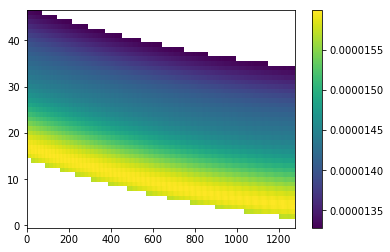

In [84]:
plt.imshow(im121-im1000, aspect='auto')
plt.colorbar()

In [85]:
diff = im121-im1000
notnan=~np.isnan(diff)
np.mean(diff[notnan])

1.463767428940503e-05

In [88]:
# Compute percentage of pixels above certain threshold
def compute_percentage(values, threshold):
    values = values[~np.isnan(values)]
    n_total = values.size
    
    thresh = [threshold, 3*threshold, 5*threshold]
    res = []
    for i in thresh:
        n = np.logical_or(values > i, values< -i).nonzero()[0].size
        res.append((n / n_total) * 100)
    return res

In [94]:
print('mean: ', np.nanmean(diff))
print('median: ', np.nanmedian(diff))
print('min: ', np.nanmin(diff))
print('max: ', np.nanmax(diff))
print('std: ', np.nanstd(diff))

mean:  1.46376742894e-05
median:  1.44733074994e-05
min:  1.32839241151e-05
max:  1.59875062686e-05
std:  8.25721351052e-07


In [95]:
ndiff = (im121-im1000)/im121
print('mean: ', np.nanmean(ndiff))
print('median: ', np.nanmedian(ndiff))
print('min: ', np.nanmin(ndiff))
print('max: ', np.nanmax(ndiff))
print('std: ', np.nanstd(ndiff))

mean:  4.24019620416e-05
median:  2.84938994804e-05
min:  -0.237224178156
max:  0.973768545967
std:  0.00627020447386


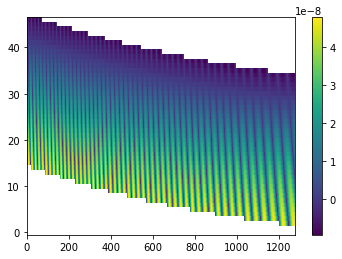

In [100]:
plt.imshow(im121_14-im1000, aspect='auto')
plt.colorbar()

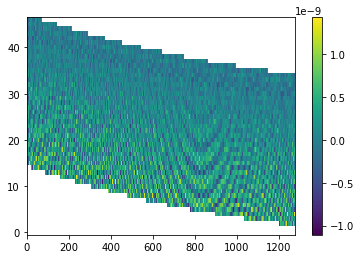

In [112]:
plt.imshow(im1000_66-im1000, aspect='auto')
plt.colorbar()